In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import keras.datasets.mnist

# 加载数据

In [2]:
(X_train,y_train),(X_test,y_test)=keras.datasets.mnist.load_data()

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
y_train.shape

(60000,)

# 特征工程
让我们将完整的训练集拆分为一个验证集和一个（较小的）训练集。 我们还将像素强度缩小到 0-1 范围并将它们转换为浮点数，除以 255，就像我们对 Fashion MNIST 所做的那样：

In [5]:
X_valid=X_train[:5000]/255
y_valid=y_train[:5000]
X_train=X_train[5000:]/255
y_train=y_train[5000:]

In [6]:
X_train.shape

(55000, 28, 28)

In [7]:
y_train.dtype

dtype('uint8')

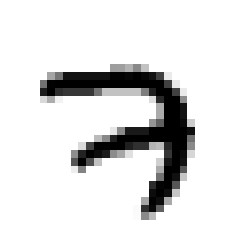

In [8]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [9]:
y_train[:10]

array([7, 3, 4, 6, 1, 8, 1, 0, 9, 8], dtype=uint8)

# 建立模型
让我们构建一个简单的密集网络并找到最佳学习率。我们需要一个回调来提高每次迭代的学习率。 它还将记录每次迭代的学习率和损失：

In [10]:
model=keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300,activation='relu'))
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dense(10,activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


我们自己写一个回调函数。

In [12]:
class ExponentialLearningRate(keras.callbacks.Callback):
    # keras.callbacks.Callback用来组建新的回调函数的抽象基类。
    def __init__(self, factor):
        self.factor = factor
        self.losses = []
        self.learning_rates = []

    # 重写on_batch_end()方法
    def on_batch_end(self, batch, logs):
        self.learning_rates.append(keras.backend.get_value(self.model.optimizer.lr))
        self.losses.append(logs['loss'])
        keras.backend.set_value(self.model.optimizer.lr,self.model.optimizer.lr*self.factor)
        # `backend.get_value` 是 `backend.set_value` 的补充，并提供一个通用接口，用于在抽象出变量的同时从变量中读取TensorFlow 1.x 和 2.x 语义之间的差异。

In [13]:
# keras.backend.clear_session()
# Keras 管理一个全局状态，它用于实现功能
# 模型构建 API 并统一自动生成的图层名称。
# 
# 如果你在一个循环中创建许多模型，这个全局状态将消耗
# 随着时间的推移越来越多的内存，您可能想要清除它。
# 调用 clear_session() 释放全局状态：这有助于避免混乱
# 来自旧模型和层，尤其是在内存有限的情况下。
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-3),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [15]:
expon_lr=ExponentialLearningRate(factor=1.005)

# 模型训练
我们首先训练一个周期。

In [16]:
model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=1,callbacks=[expon_lr])

1719/1719 [==============================] - 15s 2ms/step - loss: nan - accuracy: 0.4830 - val_loss: nan - val_accuracy: 0.0958


我们现在可以将损失绘制为学习率的函数：

Text(0,0.5,'Loss')

e:\envs\ai\lib\site-packages\matplotlib\mathtext.py:849: MathTextWarning: Font 'default' does not have a glyph for '-' [U+2212]
  MathTextWarning)
e:\envs\ai\lib\site-packages\matplotlib\mathtext.py:850: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


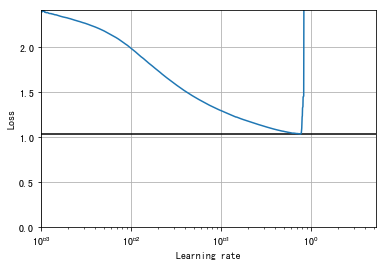

In [17]:
plt.plot(expon_lr.learning_rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.learning_rates), max(expon_lr.learning_rates))
plt.axis([min(expon_lr.learning_rates), max(expon_lr.learning_rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

当学习率超过 6e-1 时，损失开始猛烈回升，所以让我们尝试使用其中的一半，在 3e-1：

In [18]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [20]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=3e-1),
              metrics=["accuracy"])

In [21]:
import os
run_index=1
run_logdir=os.path.join(os.curdir,'my_mnist_logs','run_{0:03d}'.format(run_index))
run_logdir

'.\\my_mnist_logs\\run_001'

In [22]:
early_stopping_cb=keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb=keras.callbacks.ModelCheckpoint(filepath='./my_mnist_model.h5',save_best_only=True)
tensorboard_cb=keras.callbacks.TensorBoard(run_logdir)

In [23]:
history=model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=100,callbacks=[early_stopping_cb,checkpoint_cb,tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 5s 2ms/step - loss: 0.4200 - accuracy: 0.8677 - val_loss: 0.0975 - val_accuracy: 0.9712
Epoch 2/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0942 - accuracy: 0.9695 - val_loss: 0.0989 - val_accuracy: 0.9704
Epoch 3/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0662 - accuracy: 0.9786 - val_loss: 0.0759 - val_accuracy: 0.9766
Epoch 4/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0448 - accuracy: 0.9852 - val_loss: 0.0727 - val_accuracy: 0.9804
Epoch 5/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0344 - accuracy: 0.9887 - val_loss: 0.0865 - val_accuracy: 0.9774
Epoch 6/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0292 - accuracy: 0.9904 - val_loss: 0.0776 - val_accuracy: 0.9804
Epoch 7/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0227 - accuracy: 0.9927 - val_loss: 0.0836 - val_ac

In [24]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 19.3047 - accuracy: 0.9783


[19.30472183227539, 0.9782999753952026]